In [1]:
import numpy as np 
import pandas as pd 
import os
from tqdm import tqdm
from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image
import random
import math

from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchinfo import summary

In [2]:
DATA_ROOT = r'/kaggle/input/car-damage-severity-dataset/data3a'

TRAIN_DIR = os.path.join(DATA_ROOT, "training")
TEST_DIR = os.path.join(DATA_ROOT, "validation")

In [3]:
class_names = [
    "01-minor",
    "02-moderate",
    "03-severe"
]

class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}
idx_to_class = {idx: cls_name for cls_name, idx in class_to_idx.items()}

print(class_to_idx)

{'01-minor': 0, '02-moderate': 1, '03-severe': 2}


In [4]:
records = []

for class_name, label in class_to_idx.items():
    print(os.path.join(TRAIN_DIR, class_name))
    class_dir = Path(os.path.join(TRAIN_DIR, class_name))
    
    for img_path in tqdm(class_dir.glob("*")):
        if img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
            records.append({
                "image_path": img_path,
                "label": label,
                "class_name": class_name
            })

train_df = pd.DataFrame(records)

print(train_df.head())
print(f"Total training images: {len(train_df)}")

/kaggle/input/car-damage-severity-dataset/data3a/training/01-minor


452it [00:00, 2866.14it/s]


/kaggle/input/car-damage-severity-dataset/data3a/training/02-moderate


463it [00:00, 28250.02it/s]


/kaggle/input/car-damage-severity-dataset/data3a/training/03-severe


468it [00:00, 34102.99it/s]


                                          image_path  label class_name
0  /kaggle/input/car-damage-severity-dataset/data...      0   01-minor
1  /kaggle/input/car-damage-severity-dataset/data...      0   01-minor
2  /kaggle/input/car-damage-severity-dataset/data...      0   01-minor
3  /kaggle/input/car-damage-severity-dataset/data...      0   01-minor
4  /kaggle/input/car-damage-severity-dataset/data...      0   01-minor
Total training images: 1383


In [5]:
class_counts = (
    train_df["class_name"]
    .value_counts()
    .sort_index()
)

print(class_counts)

class_name
01-minor       452
02-moderate    463
03-severe      468
Name: count, dtype: int64


In [6]:
def show_samples(df, class_name, n=5):
    samples = df[df["class_name"] == class_name].sample(n, random_state=42)
    
    fig, axes = plt.subplots(1, n, figsize=(15, 4))
    fig.suptitle(class_name, fontsize=14)
    
    for ax, (_, row) in zip(axes, samples.iterrows()):
        img = Image.open(row["image_path"]).convert("RGB")
        ax.imshow(img)
        ax.axis("off")
    
    plt.show()

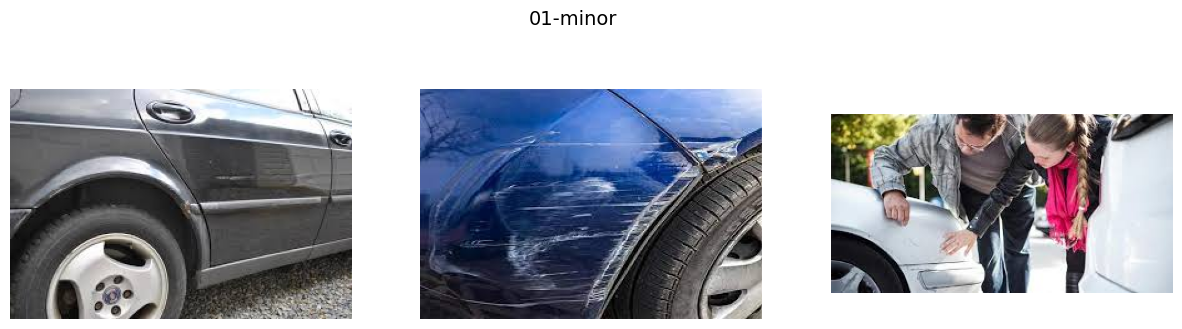

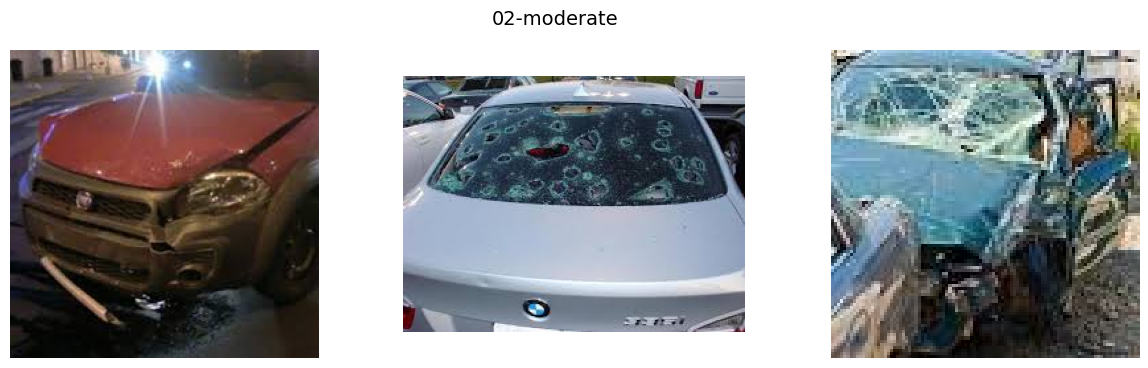

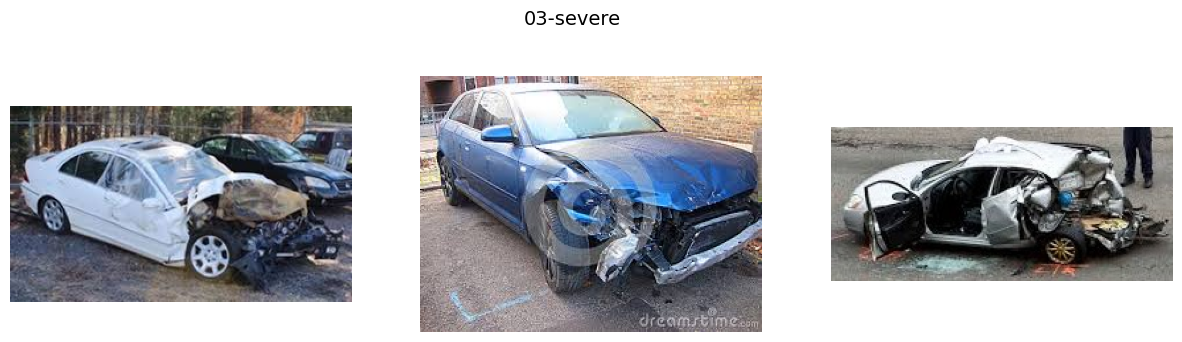

In [7]:
for cls in class_names:
    show_samples(train_df, cls, n=3)

In [8]:
class CarSeverityImageDataset(Dataset):
    def __init__(self, imgs_path, transform=None) -> None:
        self.imgs_path = Path(imgs_path)
        self.transform = transform

        print(imgs_path)
        self.files_paths = [path for path in self.imgs_path.glob("**/*") if path.is_file()]

    def __len__(self):
        return len(self.files_paths)


    def __getitem__(self, idx):
        file_path = self.files_paths[idx]

        img = Image.open(file_path).convert("RGB")

        label = file_path.parent.name
        label = class_to_idx[label]

        if self.transform:
            img = self.transform(img)

        return img, label

In [9]:
def get_loaders(batch_size, val_split = 0.1, shuffle = True, random_seed=42, input_size=224):

    train_transform = transforms.Compose([
        # Scales between 80% to 100% of the image to keep damage features visible
        transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0)),
        
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(degrees=15),

        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])


    train_dataset = CarSeverityImageDataset(TRAIN_DIR, train_transform)
    val_dataset = CarSeverityImageDataset(TRAIN_DIR, val_transforms)
    test_dataset = CarSeverityImageDataset(TEST_DIR, val_transforms)


    # Calculate split
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(val_split * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, val_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(train_dataset, batch_size, sampler=train_sampler)
    val_loader = DataLoader(val_dataset, batch_size, sampler=val_sampler)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
                               
    return train_loader, val_loader, test_loader

In [10]:
BATCH_SIZE = 16
NUM_CLASSES = 3

# Hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 0.005
WEIGHT_DECAY_RATE = 0.0005
NUM_EPOCHS = 40
WARMUP_EPOCHS = 4

INPUT_SIZE = 224

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
train_loader, val_loader, test_loader = get_loaders(BATCH_SIZE, input_size=INPUT_SIZE)

/kaggle/input/car-damage-severity-dataset/data3a/training
/kaggle/input/car-damage-severity-dataset/data3a/training
/kaggle/input/car-damage-severity-dataset/data3a/validation


# ResNet34 model

In [12]:
import torch.nn.functional as F

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.LeakyReLU(0.1, inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes):
        self.inplanes = 64
        in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.LeakyReLU(0.1, inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # He/Kaiming Initialization is best for ReLU networks
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                
            elif isinstance(m, nn.BatchNorm2d):
                # Constant init for Batch Norm
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.Linear):
                # Normal distribution for the final classifier
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        logits = self.fc(x)

        return logits


def get_resnet34(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes)
    return model

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OrdinalCrossEntropyLoss(nn.Module):
    def __init__(self, num_classes, lambda_ord=0.5):
        super().__init__()
        self.num_classes = num_classes
        self.lambda_ord = lambda_ord
        self.ce = nn.CrossEntropyLoss()

        # Precompute class index tensor
        self.register_buffer(
            "class_indices",
            torch.arange(num_classes).float()
        )

    def forward(self, logits, targets):
        """
        logits: (B, C)
        targets: (B,)
        """

        # Standard CE
        ce_loss = self.ce(logits, targets)

        # Softmax probabilities
        probs = F.softmax(logits, dim=1)

        # Expand class indices to batch
        class_indices = self.class_indices.unsqueeze(0)  # (1, C)

        # Expand targets
        targets_exp = targets.unsqueeze(1).float()       # (B, 1)

        # Compute |k - y|
        distances = torch.abs(class_indices - targets_exp)  # (B, C)

        # Expected ordinal distance
        ord_loss = torch.sum(probs * distances, dim=1).mean()

        return ce_loss + self.lambda_ord * ord_loss


In [14]:
from torch.optim.lr_scheduler import MultiStepLR, LinearLR, SequentialLR

torch.manual_seed(RANDOM_SEED)
model = get_resnet34(NUM_CLASSES)
model.to(DEVICE)

criterion = OrdinalCrossEntropyLoss(
    num_classes=3,
    lambda_ord=0.4 
).to(DEVICE)


optimizer = torch.optim.Adam(model.parameters(), 
                            lr=LEARNING_RATE, 
                            weight_decay=WEIGHT_DECAY_RATE)

warmup_scheduler = LinearLR(
    optimizer,
    start_factor=0.5,
    total_iters=WARMUP_EPOCHS
)

main_scheduler = MultiStepLR(
    optimizer,
    milestones=[10, 20, 30],
    gamma=0.75
)

scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup_scheduler, main_scheduler],
    milestones=[WARMUP_EPOCHS]
)

print(f"Model is currently on Device: {DEVICE}")
# print(summary(model, (1, 3, 224, 224)))

Model is currently on Device: cuda


In [15]:
total_steps = len(train_loader)
print(total_steps)

78


In [16]:
for epoch in range(NUM_EPOCHS):
    # Training 
    model.train()
    running_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for images, labels in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running metrics
        running_loss += loss.item() * images.size(0)
        pbar.set_postfix({'batch_loss': f"{loss.item():.4f}"})

    epoch_loss = running_loss / len(train_loader.sampler)
    
    # Get Current Learning Rate from first param group
    current_lr = optimizer.param_groups[0]['lr']

    # Validation
    model.eval()
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
    
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
            all_preds.append(preds)
            all_labels.append(labels)
    
    acc = 100 * correct / total

    if (epoch + 1) % 5 == 0:
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
    
        # Ordinal MAE
        mae = torch.abs(all_preds - all_labels).float().mean().item()
    
        # Recall per class
        recalls = {}
        for cls in range(NUM_CLASSES):
            cls_mask = all_labels == cls
            if cls_mask.sum() > 0:
                recall = (all_preds[cls_mask] == cls).float().mean().item()
                recalls[cls] = recall
            else:
                recalls[cls] = float("nan")
    
        print(
            f"[Eval @ Epoch {epoch+1}] "
            f"Acc: {acc:.2f}% | "
            f"MAE: {mae:.3f} | "
            f"Recall (Minor/Mod/Sev): "
            f"{recalls[0]:.3f} / {recalls[1]:.3f} / {recalls[2]:.3f}"
        )

    print(
        f"Summary -> LR: {current_lr:.6f} | "
        f"Train Loss: {epoch_loss:.4f} | "
        f"Val Acc: {acc:.2f}%"
    )
    print("-" * 30)
    
    scheduler.step()

Epoch 1/40: 100%|██████████| 78/78 [00:17<00:00,  4.50it/s, batch_loss=1.6961]


Summary -> LR: 0.002500 | Train Loss: 1.5198 | Val Acc: 28.26%
------------------------------


Epoch 2/40: 100%|██████████| 78/78 [00:12<00:00,  6.48it/s, batch_loss=1.3811]


Summary -> LR: 0.003125 | Train Loss: 1.3947 | Val Acc: 38.41%
------------------------------


Epoch 3/40: 100%|██████████| 78/78 [00:12<00:00,  6.30it/s, batch_loss=1.4086]


Summary -> LR: 0.003750 | Train Loss: 1.3657 | Val Acc: 47.10%
------------------------------


Epoch 4/40: 100%|██████████| 78/78 [00:12<00:00,  6.43it/s, batch_loss=1.4732]
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Summary -> LR: 0.004375 | Train Loss: 1.3524 | Val Acc: 26.81%
------------------------------


Epoch 5/40: 100%|██████████| 78/78 [00:12<00:00,  6.45it/s, batch_loss=1.2903]


[Eval @ Epoch 5] Acc: 53.62% | MAE: 0.536 | Recall (Minor/Mod/Sev): 0.754 / 0.463 / 0.300
Summary -> LR: 0.005000 | Train Loss: 1.3034 | Val Acc: 53.62%
------------------------------


Epoch 6/40: 100%|██████████| 78/78 [00:12<00:00,  6.36it/s, batch_loss=1.2746]


Summary -> LR: 0.005000 | Train Loss: 1.3820 | Val Acc: 47.10%
------------------------------


Epoch 7/40: 100%|██████████| 78/78 [00:12<00:00,  6.31it/s, batch_loss=1.2783]


Summary -> LR: 0.005000 | Train Loss: 1.2829 | Val Acc: 43.48%
------------------------------


Epoch 8/40: 100%|██████████| 78/78 [00:12<00:00,  6.28it/s, batch_loss=0.9809]


Summary -> LR: 0.005000 | Train Loss: 1.2994 | Val Acc: 50.00%
------------------------------


Epoch 9/40: 100%|██████████| 78/78 [00:12<00:00,  6.28it/s, batch_loss=1.2558]


Summary -> LR: 0.005000 | Train Loss: 1.2459 | Val Acc: 44.93%
------------------------------


Epoch 10/40: 100%|██████████| 78/78 [00:11<00:00,  6.50it/s, batch_loss=1.6100]


[Eval @ Epoch 10] Acc: 47.83% | MAE: 0.681 | Recall (Minor/Mod/Sev): 0.421 / 0.195 / 0.850
Summary -> LR: 0.005000 | Train Loss: 1.2251 | Val Acc: 47.83%
------------------------------


Epoch 11/40: 100%|██████████| 78/78 [00:12<00:00,  6.23it/s, batch_loss=1.3534]


Summary -> LR: 0.005000 | Train Loss: 1.2313 | Val Acc: 41.30%
------------------------------


Epoch 12/40: 100%|██████████| 78/78 [00:12<00:00,  6.45it/s, batch_loss=1.2504]


Summary -> LR: 0.005000 | Train Loss: 1.2464 | Val Acc: 47.10%
------------------------------


Epoch 13/40: 100%|██████████| 78/78 [00:12<00:00,  6.45it/s, batch_loss=1.0415]


Summary -> LR: 0.005000 | Train Loss: 1.2334 | Val Acc: 36.96%
------------------------------


Epoch 14/40: 100%|██████████| 78/78 [00:12<00:00,  6.46it/s, batch_loss=1.2393]


Summary -> LR: 0.005000 | Train Loss: 1.2335 | Val Acc: 59.42%
------------------------------


Epoch 15/40: 100%|██████████| 78/78 [00:11<00:00,  6.54it/s, batch_loss=1.0571]


[Eval @ Epoch 15] Acc: 42.03% | MAE: 0.775 | Recall (Minor/Mod/Sev): 0.281 / 0.146 / 0.900
Summary -> LR: 0.003750 | Train Loss: 1.2012 | Val Acc: 42.03%
------------------------------


Epoch 16/40: 100%|██████████| 78/78 [00:11<00:00,  6.55it/s, batch_loss=1.2391]


Summary -> LR: 0.003750 | Train Loss: 1.2137 | Val Acc: 52.90%
------------------------------


Epoch 17/40: 100%|██████████| 78/78 [00:11<00:00,  6.63it/s, batch_loss=1.2204]


Summary -> LR: 0.003750 | Train Loss: 1.2077 | Val Acc: 60.14%
------------------------------


Epoch 18/40: 100%|██████████| 78/78 [00:11<00:00,  6.64it/s, batch_loss=1.4568]


Summary -> LR: 0.003750 | Train Loss: 1.1867 | Val Acc: 41.30%
------------------------------


Epoch 19/40: 100%|██████████| 78/78 [00:11<00:00,  6.57it/s, batch_loss=1.1697]


Summary -> LR: 0.003750 | Train Loss: 1.2075 | Val Acc: 63.04%
------------------------------


Epoch 20/40: 100%|██████████| 78/78 [00:12<00:00,  6.49it/s, batch_loss=1.1358]


[Eval @ Epoch 20] Acc: 54.35% | MAE: 0.536 | Recall (Minor/Mod/Sev): 0.404 / 0.463 / 0.825
Summary -> LR: 0.003750 | Train Loss: 1.1622 | Val Acc: 54.35%
------------------------------


Epoch 21/40: 100%|██████████| 78/78 [00:11<00:00,  6.71it/s, batch_loss=1.3059]


Summary -> LR: 0.003750 | Train Loss: 1.1811 | Val Acc: 55.07%
------------------------------


Epoch 22/40: 100%|██████████| 78/78 [00:11<00:00,  6.60it/s, batch_loss=1.1887]


Summary -> LR: 0.003750 | Train Loss: 1.1851 | Val Acc: 65.22%
------------------------------


Epoch 23/40: 100%|██████████| 78/78 [00:11<00:00,  6.62it/s, batch_loss=1.1050]


Summary -> LR: 0.003750 | Train Loss: 1.1514 | Val Acc: 54.35%
------------------------------


Epoch 24/40: 100%|██████████| 78/78 [00:11<00:00,  6.57it/s, batch_loss=1.1555]


Summary -> LR: 0.003750 | Train Loss: 1.1677 | Val Acc: 55.07%
------------------------------


Epoch 25/40: 100%|██████████| 78/78 [00:11<00:00,  6.74it/s, batch_loss=0.9353]


[Eval @ Epoch 25] Acc: 54.35% | MAE: 0.514 | Recall (Minor/Mod/Sev): 0.421 / 0.561 / 0.700
Summary -> LR: 0.002812 | Train Loss: 1.1842 | Val Acc: 54.35%
------------------------------


Epoch 26/40: 100%|██████████| 78/78 [00:11<00:00,  6.53it/s, batch_loss=1.0727]


Summary -> LR: 0.002812 | Train Loss: 1.1668 | Val Acc: 50.72%
------------------------------


Epoch 27/40: 100%|██████████| 78/78 [00:11<00:00,  6.58it/s, batch_loss=1.1836]


Summary -> LR: 0.002812 | Train Loss: 1.1456 | Val Acc: 52.90%
------------------------------


Epoch 28/40: 100%|██████████| 78/78 [00:11<00:00,  6.56it/s, batch_loss=1.4831]


Summary -> LR: 0.002812 | Train Loss: 1.1668 | Val Acc: 35.51%
------------------------------


Epoch 29/40: 100%|██████████| 78/78 [00:11<00:00,  6.59it/s, batch_loss=1.3931]


Summary -> LR: 0.002812 | Train Loss: 1.1587 | Val Acc: 55.07%
------------------------------


Epoch 30/40: 100%|██████████| 78/78 [00:12<00:00,  6.41it/s, batch_loss=1.2571]


[Eval @ Epoch 30] Acc: 47.83% | MAE: 0.645 | Recall (Minor/Mod/Sev): 0.491 / 0.171 / 0.775
Summary -> LR: 0.002812 | Train Loss: 1.1418 | Val Acc: 47.83%
------------------------------


Epoch 31/40: 100%|██████████| 78/78 [00:12<00:00,  6.48it/s, batch_loss=1.1937]


Summary -> LR: 0.002812 | Train Loss: 1.1500 | Val Acc: 57.97%
------------------------------


Epoch 32/40: 100%|██████████| 78/78 [00:12<00:00,  6.41it/s, batch_loss=0.8382]


Summary -> LR: 0.002812 | Train Loss: 1.1514 | Val Acc: 52.17%
------------------------------


Epoch 33/40: 100%|██████████| 78/78 [00:11<00:00,  6.51it/s, batch_loss=0.9238]


Summary -> LR: 0.002812 | Train Loss: 1.1429 | Val Acc: 54.35%
------------------------------


Epoch 34/40: 100%|██████████| 78/78 [00:11<00:00,  6.65it/s, batch_loss=1.4067]


Summary -> LR: 0.002812 | Train Loss: 1.1282 | Val Acc: 60.87%
------------------------------


Epoch 35/40: 100%|██████████| 78/78 [00:12<00:00,  6.50it/s, batch_loss=0.9662]


[Eval @ Epoch 35] Acc: 47.10% | MAE: 0.645 | Recall (Minor/Mod/Sev): 0.368 / 0.195 / 0.900
Summary -> LR: 0.002109 | Train Loss: 1.1268 | Val Acc: 47.10%
------------------------------


Epoch 36/40: 100%|██████████| 78/78 [00:12<00:00,  6.44it/s, batch_loss=0.8617]


Summary -> LR: 0.002109 | Train Loss: 1.1333 | Val Acc: 60.14%
------------------------------


Epoch 37/40: 100%|██████████| 78/78 [00:12<00:00,  6.43it/s, batch_loss=0.9028]


Summary -> LR: 0.002109 | Train Loss: 1.1128 | Val Acc: 61.59%
------------------------------


Epoch 38/40: 100%|██████████| 78/78 [00:11<00:00,  6.54it/s, batch_loss=1.2387]


Summary -> LR: 0.002109 | Train Loss: 1.1458 | Val Acc: 61.59%
------------------------------


Epoch 39/40: 100%|██████████| 78/78 [00:11<00:00,  6.69it/s, batch_loss=0.9154]


Summary -> LR: 0.002109 | Train Loss: 1.1173 | Val Acc: 64.49%
------------------------------


Epoch 40/40: 100%|██████████| 78/78 [00:12<00:00,  6.33it/s, batch_loss=1.2706]


[Eval @ Epoch 40] Acc: 60.14% | MAE: 0.442 | Recall (Minor/Mod/Sev): 0.649 / 0.463 / 0.675
Summary -> LR: 0.002109 | Train Loss: 1.1204 | Val Acc: 60.14%
------------------------------


In [18]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print(f'Test accuracy: {100 * correct / total:.2f} %')

Test accuracy: 61.69 %


In [19]:
PATH = "entire_model.pt"
torch.save(model, PATH)